## Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import nlp
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

c:\Users\isapr\tweet-emotion-recogniton\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing Data

In [3]:
data = pd.read_pickle("data/merged_training.pkl")
data.reset_index(drop=True, inplace=True)
data.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(),
                                                                    data.emotions.to_numpy(),
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.head()

,text,class
0,i grew up feeling ugly,sadness
1,i find such literature helps me feel relaxed a...,joy
2,i think the feeling that i have is that i don ...,surprise
3,ill think my way to a solution on how to not l...,sadness
4,im looking forward to seeing familiar faces ag...,sadness


In [5]:
def get_tweet(data):
    tweets = data['text'].tolist()
    labels = data['class'].tolist()
    return tweets, labels

tweets, labels = get_tweet(train_dataset)
tweets[0], labels[0]

('i grew up feeling ugly', 'sadness')

## Tokenizer

1. Tokenizing the tweets

- Turns text into sequences of integers that can be fed into models

- Only keep the 10,000 most common words in the training data

#### Example
tweets = ["I'm happy today", "Feeling very sad", "This is amazing"]

tokenizer.word_index → {'<OOV>': 1, 'i': 2, 'am': 3, 'happy': 4, 'today': 5, ...}

"texts_to_sequences" converts it into a list of integer tokens using the word index.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)
tokenizer.texts_to_sequences([tweets[0]])

[[2, 1653, 42, 8, 513]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

Standardize the length of input sequences so that they are all the same size, which is necessary for neural networks to process them correctly.

- Converts each tweet (text) into a sequence of integers, where each integer represents a word based on the vocabulary learned by the tokenizer

- Padding ensures that all inputs are fixed in size, allowing batch training.

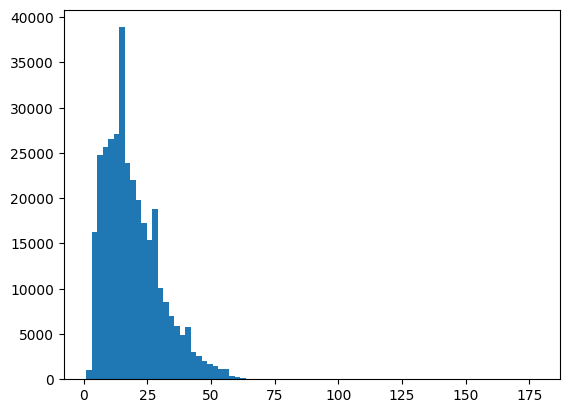

In [7]:
lenghts = [len(tweet.split()) for tweet in tweets]
plt.hist(lenghts, bins=len(set(lenghts)))
plt.show()

In [8]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

padded_train = get_sequences(tokenizer, tweets)
padded_train[0]

array([   2, 1653,   42,    8,  513,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

Creates a mapping between text labels and numeric values, which is essential for training machine learning models that operate on numbers.
- It generates two dictionaries: class_to_index, which converts class names to indices, and index_to_class, which does the reverse conversion.
- It then defines a function names_to_ids that transforms a list of text labels into a NumPy array with the corresponding indices. This allows you to represent the labels of the training samples in numeric format, which is necessary for training the model.

{'fear', 'anger', 'love', 'sadness', 'surprise', 'joy'}


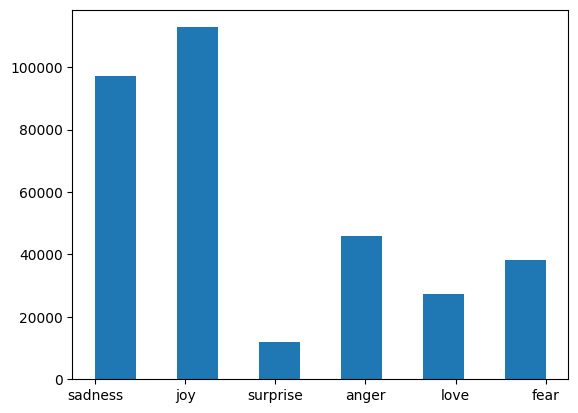

In [9]:
classes = set(labels)
print(classes)

plt.hist(labels, bins=11)
plt.show()

In [10]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

class_to_index
index_to_class

names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

- Embedding turns word indices into dense vectors (word embeddings) where 10000 is the vocabulary size (maximum number of unique tokens to consider) and 16: the dimension of each embedding vector.

- Passes the embeddings through stacked bidirectional LSTM layers to learn temporal features. LSTM stands for Long Short-Term Memory. It is a type of Recurrent Neural Network (RNN) layer designed to learn from sequences, especially when long-term dependencies matter.

- Uses Adam as a optimizer that adapts the learning rate.

- Outputs probabilities over 6 classes using a softmax layer.


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

c:\Users\isapr\tweet-emotion-recogniton\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Training the Model

1. Preparing a validation set
2. Training the model

In [12]:
val_tweets, val_labels = get_tweet(train_dataset)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [13]:
h = model.fit(
    padded_train, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

os.makedirs("../app/model", exist_ok=True)

model.save("../app/model/tf_model.keras")

joblib.dump(tokenizer, "../app/model/tokenizer.pkl")

Epoch 1/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1224s 117ms/step - accuracy: 0.8871 - loss: 0.2740 - val_accuracy: 0.9384 - val_loss: 0.1081
Epoch 2/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1424s 136ms/step - accuracy: 0.9376 - loss: 0.1025 - val_accuracy: 0.9413 - val_loss: 0.0934
Epoch 3/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1201s 115ms/step - accuracy: 0.9405 - loss: 0.0941 - val_accuracy: 0.9417 - val_loss: 0.0922
Epoch 4/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1169s 112ms/step - accuracy: 0.9411 - loss: 0.0897 - val_accuracy: 0.9426 - val_loss: 0.0872
Epoch 5/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 995s 95ms/step - accuracy: 0.9422 - loss: 0.0876 - val_accuracy: 0.9436 - val_loss: 0.0862
Epoch 6/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 995s 95ms/step - accuracy: 0.9429 - loss: 0.0859 - val_accuracy: 0.9441 - val_loss: 0.0829
Epoch 7/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1023s 98ms/step - accuracy: 0.9433 - loss: 0.0847 - val_accuracy: 0.9444 - val_loss: 0.0824
Epoch 8/10
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 10

['../app/model/tokenizer.pkl']

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

In [14]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()



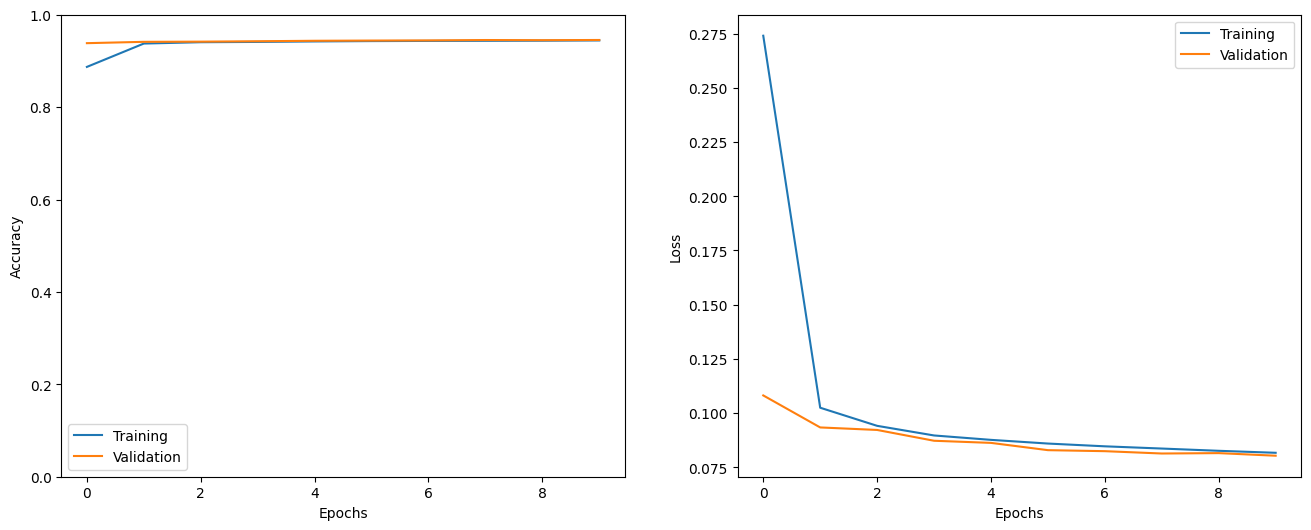

In [15]:
show_history(h)

In [16]:
test_tweets, test_labels = get_tweet(test_dataset)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [17]:
_ = model.evaluate(test_seq, test_labels)

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.9360 - loss: 0.1009


In [21]:
import random
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i feel are simply divine
Emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Predicted Emotion: joy


1303/1303 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step


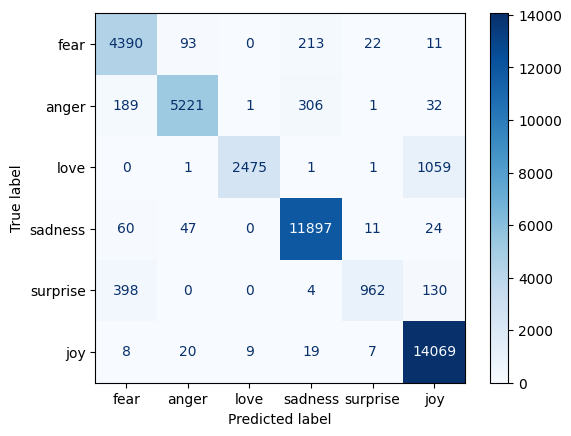

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = model.predict(test_seq)

pred_labels = np.argmax(preds, axis=1)
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')